In [ ]:
import os

import numpy as np
from PIL import Image
from tqdm import tqdm
from datasets import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings("ignore")

## Data preprocessing

In [2]:
class PokemonDataset:
    """
    A dataset class for loading and processing images of Pokemon.

    This class handles loading images from a directory, resizing them,
    converting them to tensors, and performing data augmentation for
    model training. It also provides a method to split the data into 
    training and testing sets.

    Attributes:
        data_dir (str): Path to the directory containing Pokemon images.
        pokemons_names (list): List of Pokemon names corresponding to subdirectories.
        data (list): List of processed image tensors.
        labels (list): List of integer labels corresponding to each image.
    """

    def __init__(self, data_dir: str):
        """
        Initializes the PokemonDataset object.

        Args:
            data_dir (str): Path to the directory containing Pokemon images.
        """
        self.data_dir = data_dir
        self.pokemons_names = os.listdir(data_dir)
        self.data = []
        self.labels = []
        self.prepare_dataset()

    def load_image(self, filepath: str):
        """
        Loads an image from the specified file path and converts it to RGB.

        Args:
            filepath (str): Path to the image file.

        Returns:
            PIL.Image: The loaded image in RGB mode.
        """
        return Image.open(filepath).convert("RGB")

    def get_images_for_one_pokemon(self, pokemon_name: str):
        """
        Loads and resizes all images for a given Pokemon name.

        Args:
            pokemon_name (str): The name of the Pokemon whose images to load.

        Returns:
            list: A list of resized PIL.Image objects for the Pokemon.
        """
        pokemon_dir = os.path.join(self.data_dir, pokemon_name)
        paths = os.listdir(pokemon_dir)
        images = [self.load_image(os.path.join(pokemon_dir, path)) for path in paths]
        resized_images = list(map(transforms.Resize((64, 64)), images))
        return resized_images

    def prepare_dataset(self):
        """
        Prepares the dataset by loading, resizing, and converting images to tensors.
        It also generates corresponding labels for each image.
        """
        for idx, name in enumerate(self.pokemons_names):
            images = self.get_images_for_one_pokemon(name)
            images = [ToTensor()(image) for image in images]
            self.data.extend(images)
            self.labels.extend([idx] * len(images))

    def train_test_split(self):
        """
        Splits the dataset into training and testing sets. 
        Ensures at least one sample per class is included in the test set.

        Returns:
            tuple: 
                - train_dataset (Dataset): Training dataset with augmented images.
                - train_original_dataset (Dataset): Original training dataset without augmentation.
                - test_dataset (Dataset): Testing dataset.
        """
        train_data, test_data, train_labels, test_labels = [], [], [], []
        class_to_samples = {}

        # Group samples by class
        for sample, label in zip(self.data, self.labels):
            class_to_samples[label] = class_to_samples.get(label, []) + [sample]

        # Split into train and test sets
        for label, samples in class_to_samples.items():
            train_data.extend(samples[:-1])
            train_labels.extend([label] * (len(samples) - 1))
            if len(samples) > 1:
                test_data.append(samples[-1])
                test_labels.append(label)

        # Augment the training data
        train_data_augmented, train_labels_augmented = self.augment_data(train_data, train_labels)

        # Create Hugging Face Datasets
        train_dataset = Dataset.from_dict({
            "image": train_data + train_data_augmented, 
            "label": train_labels + train_labels_augmented
        })
        train_original_dataset = Dataset.from_dict({
            "image": train_data, 
            "label": train_labels
        })
        test_dataset = Dataset.from_dict({
            "image": test_data, 
            "label": test_labels
        })

        return train_dataset, train_original_dataset, test_dataset

    def augment_image(self, image, n_augmented_images: int = 20):
        """
        Generates augmented images for a given input image.

        Args:
            image (Tensor): The input image to augment.
            n_augmented_images (int): Number of augmented images to generate. Default is 10.

        Returns:
            list: A list of augmented images as tensors.
        """
        augmentations = [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=np.random.uniform(1, 90)),
            transforms.GaussianBlur(kernel_size=(3, 3)),
            transforms.RandomAffine(degrees=np.random.uniform(1, 90)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
            transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0)
        ]

        return [
            transforms.Compose([
                transforms.RandomChoice([
                    transforms.RandomApply([aug], p=0.5) for aug in augmentations
                ])
            ])(image) for _ in range(n_augmented_images)
        ]

    def augment_data(self, X, y):
        """
        Augments the training data by generating new images using data augmentation techniques.

        Args:
            X (list): List of input images as tensors.
            y (list): List of corresponding labels for the input images.

        Returns:
            tuple:
                - augmented_data_X (list): List of augmented images.
                - augmented_data_y (list): Corresponding labels for the augmented images.
        """
        augmented_data_X, augmented_data_y = [], []
        for sample_X, sample_y in zip(X, y):
            new_images = self.augment_image(image=sample_X)
            augmented_data_X.extend(new_images)
            augmented_data_y.extend([sample_y] * len(new_images))
        return augmented_data_X, augmented_data_y

In [3]:
# Load dataset
dataset = PokemonDataset(data_dir="../data/pokemons/")

print(f"Unique Pokemons: {len(dataset.pokemons_names)}")
print(f"Images per Pokemon on average: {len(dataset.labels) // len(dataset.pokemons_names)}")

Unique Pokemons: 898
Images per Pokemon on average: 2


### Split dataset into train and test, augment the training data

In [4]:
train_dataset, train_original_dataset, test_dataset = dataset.train_test_split()

In [5]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 33705
})

### Note:

Test contains one image per Pokemon.

But there are 54 pokemonts that are represented by only one exemplar. Those were put into the training dataset.

In [6]:
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 844
})

# Prepare input data

In [7]:
BATCH_SIZE = 16

# Change sequence for the data loader
def collate_batch(batch):
    imgs = [item["image"] for item in batch]
    imgs = torch.tensor(imgs)
    targets = list(map(lambda item: item["label"], batch))
    targets = torch.tensor(targets)
    return imgs, targets

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
train_original_loader = DataLoader(train_original_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

# Define a neural network architecture

In [8]:
class PokemonNet(nn.Module):
    def __init__(self, num_classes: int):
        super(PokemonNet, self).__init__()
    
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
    
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(3136, num_classes)

    def forward(self, x):
        # Block 1
        y = self.conv1(x)
        y = self.bn1(y)
        y = self.relu1(y)
        y = self.pool1(y)
    
        # Block 2
        y = self.conv2(y)
        y = self.bn2(y)
        y = self.relu2(y)
        y = self.pool2(y)

        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        return y

# Set up training

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
match device.type:
    case "cuda":
        print(f"Device: {torch.cuda.get_device_name()}")
    case "cpu":
        print("Device: CPU")

Device: NVIDIA GeForce RTX 4060


In [10]:
# Initialize model, loss function, and optimizer
model = PokemonNet(num_classes=len(dataset.pokemons_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
n_samples: int = train_dataset.num_rows
n_iters_per_epoch: int = n_samples // BATCH_SIZE

In [12]:
# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='logs')

def evaluate_model(data_loader: DataLoader, phase: str, iteration: int):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average="micro")
    precision = precision_score(all_labels, all_preds, average="micro")

    # Log accuracy to TensorBoard
    writer.add_scalar(f'{phase}/Accuracy', accuracy, iteration)
    writer.add_scalar(f'{phase}/Recall', recall, iteration)
    writer.add_scalar(f'{phase}/Precision', precision, iteration)
    
    return accuracy

n_epochs: int = 5

for epoch in range(n_epochs):
    model.train()
    running_loss: float = 0.0
    progress_bar: tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}, Loss: inf')
    
    for idx, (images, labels) in enumerate(progress_bar):
        iteration: int = epoch * len(train_loader) + idx
    
        # Halve the learning rate every 1000 iterations (for better convergence)
        if iteration > 0 and iteration % 1000 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.5

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        running_loss += loss.item()
        
        # Update tqdm bar description with the current loss
        progress_bar.set_description(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}')

        # Log loss to TensorBoard
        writer.add_scalar('Train/Loss', loss.item(), iteration)

        # Evaluate and log accuracy every 100 iterations
        if iteration % 200 == 0:
            train_acc = evaluate_model(train_original_loader, 'Train', iteration)
            test_acc = evaluate_model(test_loader, 'Test', iteration)
            model.train()

    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{n_epochs}], Avg Loss: {avg_loss:.4f}')

# Close the writer
writer.close()

Epoch 1/5, Loss: 2.1726: 100%|██████████| 2107/2107 [06:33<00:00,  5.35it/s]  


Epoch [1/5], Avg Loss: 1.1923


Epoch 2/5, Loss: 0.0196: 100%|██████████| 2107/2107 [06:43<00:00,  5.23it/s]  


Epoch [2/5], Avg Loss: 0.0876


Epoch 3/5, Loss: 0.0019: 100%|██████████| 2107/2107 [06:26<00:00,  5.45it/s] 


Epoch [3/5], Avg Loss: 0.0287


Epoch 4/5, Loss: 0.0050: 100%|██████████| 2107/2107 [07:10<00:00,  4.89it/s]  


Epoch [4/5], Avg Loss: 0.0176


Epoch 5/5, Loss: 0.0010: 100%|██████████| 2107/2107 [06:46<00:00,  5.18it/s]  

Epoch [5/5], Avg Loss: 0.0171


# Saving & Loading Model for Inference

In [13]:
# Save
torch.save(model.state_dict(), "model_checkpoint")

In [14]:
# Load
model = PokemonNet(num_classes=len(dataset.pokemons_names)).to(device)
model.load_state_dict(torch.load("model_checkpoint", weights_only=True))
model.eval();

### Is model confident in its predictions?

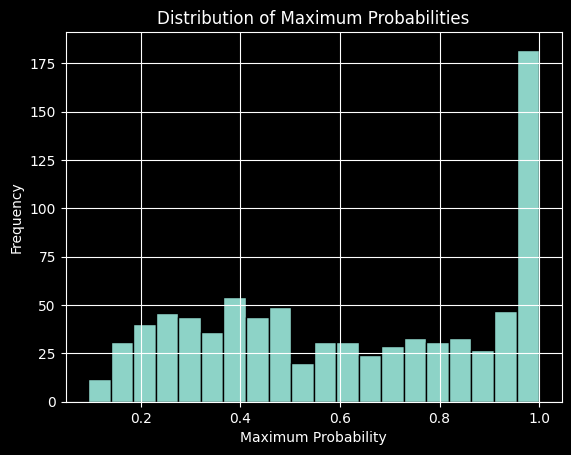

In [15]:
max_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Convert raw outputs to probabilities
        probs = F.softmax(outputs, dim=1)
        # Get maximum probas for each image
        max_batch_probs = torch.max(probs, dim=1).values.cpu().numpy()
        # Keep these probas
        max_probs.extend(max_batch_probs)

# Visualization
max_probs = np.array(max_probs)
plt.hist(max_probs, bins=20, edgecolor='black')
plt.title('Distribution of Maximum Probabilities')
plt.xlabel('Maximum Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### The plot clearly indicates that the model is very uncertain in most cases.

# Insights, Observations, and Conclusions

- Training without augmentation is ineffective due to the limited amount of data (only 1–5 samples per class).
- Diversifying the types of augmentations significantly improved performance.
- Utilizing batch normalization layers greatly enhanced convergence.
- Reducing three channels (RGB) to one (grayscale) severely degraded performance. Apparently, color plays a crucial role in distinguishing Pokemon.
- Initial augmentation provided substantial improvements, but the quality gains diminished exponentially as the number of augmented samples increased.
- Different activation functions were tested (ReLU, Sigmoid, CELU, GELU, Tanh), but none outperformed ReLU.
- **Main Problem:** Stochastic loss after ~1000 iterations, primarily caused by insufficient data.
- Small batch size (say, 16) improved convergence.
- A model with two convolutional blocks (Conv-BN-ReLU-Pool) performed better than models with one or three blocks.
- Pokemon exhibit high variability. Large batch sizes negatively impacted performance.
- Using a custom train-test split improved accuracy from 30% to 40%.
- Possible improvements: collect more data, reduce overfittig (i.e. add dropouts)

# Plots: see ```hw02/plots```